In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
df = pd.read_csv("ml-latest-small/ratings.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'ml-latest-small/ratings.csv'

In [ ]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
df.userId.nunique()

610

In [ ]:
df.movieId.nunique()

9724

In [ ]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [ ]:
df.shape

(100836, 4)

#### Training Dataset Class Wrapper

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1]
    def __getitem__(self, item):

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

#### Create the model

In [ ]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors

        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)


    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)

        return output

In [ ]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)



In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

dataiter = iter(train_loader)
dataloader_data = dataiter.next()
print(dataloader_data)

{'users': tensor([104, 237, 119, 315]), 'movies': tensor([5915, 3602,  615, 2956]), 'ratings': tensor([3, 3, 2, 2])}


In [ ]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [ ]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
90752


#### Manually run a forward path

In [ ]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)


tensor([104, 237, 119, 315])
torch.Size([4])
tensor([5915, 3602,  615, 2956])
torch.Size([4])


In [ ]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[ 0.5085, -1.2272, -0.4726,  0.7905, -0.2767, -0.0153,  1.1113, -1.2986,
          1.2292,  0.0888, -1.0573, -1.1625, -0.1311, -0.0053, -0.5241,  0.7708,
         -0.4896,  0.6567, -0.0131,  1.0754, -0.9080, -0.4787,  1.0949, -0.1798,
          1.0959,  1.0830,  0.9492,  0.6027,  1.5690, -0.5419,  0.8110,  1.6415],
        [ 0.3420, -1.0358, -0.2029,  0.6788,  0.9514, -1.4962,  0.0181,  0.7476,
          0.6486,  1.3971, -0.4799, -0.9394, -1.1288, -0.7662,  0.2478,  0.8109,
          2.0377, -0.4126, -1.7261,  0.4788, -0.1024,  0.0656,  0.7598, -0.3619,
          0.8598, -3.2272, -0.5464, -0.3262, -2.0593, -0.1117, -1.0245,  2.0310],
        [-0.9008, -1.2089, -1.1326, -0.0455,  0.7510,  1.3659, -0.5731,  0.1536,
         -0.3836, -1.3512, -0.3149, -1.3405,  1.8935,  0.7414, -0.0424, -0.3442,
          0.8125, -0.3832,  0.2406,  2.0582,  0.6443, -0.4725,  3.3729, -0.1368,
         -0.6642,  0.3662, -1.6776, -1.0803,  0.7294, -1.6338, 

In [ ]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[ 0.5085, -1.2272, -0.4726,  0.7905, -0.2767, -0.0153,  1.1113, -1.2986,
          1.2292,  0.0888, -1.0573, -1.1625, -0.1311, -0.0053, -0.5241,  0.7708,
         -0.4896,  0.6567, -0.0131,  1.0754, -0.9080, -0.4787,  1.0949, -0.1798,
          1.0959,  1.0830,  0.9492,  0.6027,  1.5690, -0.5419,  0.8110,  1.6415,
          0.5817, -0.2444,  1.1832,  0.7787,  0.1753, -0.5215,  0.9428, -0.5776,
         -1.9390, -0.6567, -0.9254, -0.1676,  0.3631,  0.4623,  0.1044, -0.3662,
         -0.1997,  0.8991,  0.4906,  0.3158,  0.0482, -0.0589, -0.9447,  0.4663,
         -0.3175, -1.4573, -0.9489,  2.3559, -0.3809, -0.8248, -0.4644, -1.4519],
        [ 0.3420, -1.0358, -0.2029,  0.6788,  0.9514, -1.4962,  0.0181,  0.7476,
          0.6486,  1.3971, -0.4799, -0.9394, -1.1288, -0.7662,  0.2478,  0.8109,
          2.0377, -0.4126, -1.7261,  0.4788, -0.1024,  0.0656,  0.7598, -0.3619,
          0.8598, -3.2272, -0.5464, -0.3262, -2.0593, -0.1117, -1.0245, 

In [ ]:
with torch.no_grad():
    model_output = model(dataloader_data['users'],
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[ 0.3611],
        [-0.0188],
        [-1.3736],
        [ 1.1189]]), size: torch.Size([4, 1])


In [ ]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([3, 3, 2, 2])
tensor([[3],
        [3],
        [2],
        [2]])
tensor([[ 0.3611],
        [-0.0188],
        [-1.3736],
        [ 1.1189]])
tensor(10)
tensor(-9.9123)


#### Run the training loop

In [ ]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"],
                       train_data["movies"]
                      )

        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])


        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

epoch 0 loss at step: 5000 is 0.45927850272133947
epoch 0 loss at step: 10000 is 0.17046366242468358
epoch 0 loss at step: 15000 is 0.1046923010814935
epoch 0 loss at step: 20000 is 0.08255441872440279
epoch 0 loss at step: 25000 is 0.0731525380147621
epoch 0 loss at step: 30000 is 0.06745479929773136
epoch 0 loss at step: 35000 is 0.06301258918857201
epoch 0 loss at step: 40000 is 0.06413749751420691
epoch 0 loss at step: 45000 is 0.06126686855272856
epoch 0 loss at step: 50000 is 0.06031981329619884
epoch 0 loss at step: 55000 is 0.05817642838675529
epoch 0 loss at step: 60000 is 0.058150451759435236
epoch 0 loss at step: 65000 is 0.05804056208669208
epoch 0 loss at step: 70000 is 0.05924356380412355
epoch 0 loss at step: 75000 is 0.05727291701959912
epoch 0 loss at step: 80000 is 0.05728691964908503
epoch 0 loss at step: 85000 is 0.05746560863703489
epoch 0 loss at step: 90000 is 0.05870871929535642


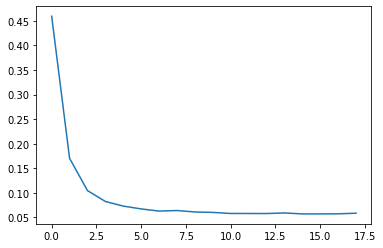

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

##### Evaluation with RMSE


In [ ]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'],
                       batched_data["movies"])

        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]

        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

model_output: tensor([[2.8938],
        [3.5610],
        [3.2030],
        [3.7048]]), target_rating: tensor([3, 4, 5, 4])
model_output: tensor([[3.6121],
        [2.6826],
        [4.3165],
        [3.1765]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.0059],
        [3.4902],
        [3.0019],
        [4.1359]]), target_rating: tensor([3, 3, 1, 4])
model_output: tensor([[3.2035],
        [3.7918],
        [3.5601],
        [4.2992]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.5342],
        [2.9639],
        [4.5760],
        [3.5263]]), target_rating: tensor([3, 2, 4, 3])
model_output: tensor([[3.3070],
        [3.8680],
        [2.7311],
        [3.0402]]), target_rating: tensor([4, 5, 3, 3])
model_output: tensor([[3.5638],
        [3.9877],
        [3.8594],
        [2.0333]]), target_rating: tensor([3, 5, 2, 5])
model_output: tensor([[3.2311],
        [3.2974],
        [3.3700],
        [3.5092]]), target_rating: tensor([4, 3, 3, 3])
model_ou

model_output: tensor([[3.6330],
        [3.4791],
        [2.5268],
        [3.5412]]), target_rating: tensor([2, 5, 4, 5])
model_output: tensor([[3.9555],
        [2.8219],
        [2.8044],
        [3.0890]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[2.8838],
        [4.0103],
        [2.3726],
        [3.0994]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.2691],
        [2.9124],
        [3.7761],
        [3.0084]]), target_rating: tensor([4, 0, 4, 3])
model_output: tensor([[3.1883],
        [3.6741],
        [3.2218],
        [2.9404]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[2.8414],
        [3.9556],
        [3.3257],
        [2.2332]]), target_rating: tensor([3, 4, 3, 2])
model_output: tensor([[3.7733],
        [2.8569],
        [3.3461],
        [2.6120]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[3.7880],
        [5.0154],
        [4.2980],
        [3.3104]]), target_rating: tensor([4, 5, 4, 4])
model_ou

model_output: tensor([[2.7111],
        [2.5995],
        [2.7423],
        [3.5940]]), target_rating: tensor([4, 3, 2, 3])
model_output: tensor([[3.4341],
        [3.6680],
        [2.6938],
        [3.9443]]), target_rating: tensor([3, 2, 3, 5])
model_output: tensor([[3.3592],
        [2.2727],
        [4.4552],
        [3.5222]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.2598],
        [3.1185],
        [3.1430],
        [3.4424]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[4.1558],
        [2.5833],
        [2.8304],
        [2.7954]]), target_rating: tensor([4, 3, 2, 2])
model_output: tensor([[3.3204],
        [3.1345],
        [3.7860],
        [3.7640]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.9827],
        [3.1620],
        [3.3654],
        [2.7774]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[3.5957],
        [3.4091],
        [3.1994],
        [3.6814]]), target_rating: tensor([3, 4, 4, 4])
model_ou

model_output: tensor([[4.3563],
        [3.7219],
        [3.1543],
        [3.1023]]), target_rating: tensor([3, 3, 2, 3])
model_output: tensor([[2.3599],
        [2.7149],
        [3.0596],
        [3.5198]]), target_rating: tensor([1, 2, 3, 4])
model_output: tensor([[2.4179],
        [3.2830],
        [3.2944],
        [3.6294]]), target_rating: tensor([1, 2, 2, 3])
model_output: tensor([[3.6338],
        [3.8752],
        [3.3204],
        [3.9410]]), target_rating: tensor([4, 4, 3, 4])
model_output: tensor([[3.1937],
        [2.7153],
        [3.3915],
        [3.2328]]), target_rating: tensor([3, 2, 0, 3])
model_output: tensor([[2.9321],
        [4.3725],
        [3.7618],
        [2.7533]]), target_rating: tensor([4, 5, 2, 3])
model_output: tensor([[3.7655],
        [3.6126],
        [2.7465],
        [2.6574]]), target_rating: tensor([5, 3, 2, 2])
model_output: tensor([[3.4631],
        [1.9862],
        [3.6638],
        [4.6417]]), target_rating: tensor([2, 1, 4, 4])
model_ou

model_output: tensor([[3.3937],
        [2.9272],
        [4.1970],
        [3.7764]]), target_rating: tensor([0, 3, 4, 5])
model_output: tensor([[4.0201],
        [3.6557],
        [3.0023],
        [3.6994]]), target_rating: tensor([3, 3, 3, 5])
model_output: tensor([[3.6755],
        [3.3295],
        [3.9726],
        [3.2410]]), target_rating: tensor([4, 4, 4, 5])
model_output: tensor([[3.5658],
        [3.2739],
        [3.4284],
        [3.4571]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[3.7004],
        [2.8160],
        [3.3203],
        [3.0768]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[2.2091],
        [3.1685],
        [3.4612],
        [4.3825]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.6451],
        [3.5482],
        [3.3661],
        [4.3563]]), target_rating: tensor([3, 5, 4, 4])
model_output: tensor([[3.8622],
        [3.0181],
        [3.1002],
        [3.8368]]), target_rating: tensor([4, 3, 4, 4])
model_ou

model_output: tensor([[2.4644],
        [2.9214],
        [3.3924],
        [2.8234]]), target_rating: tensor([3, 2, 4, 4])
model_output: tensor([[4.2386],
        [2.5056],
        [3.7391],
        [4.3107]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[2.5674],
        [3.4090],
        [3.9649],
        [4.0038]]), target_rating: tensor([1, 3, 4, 5])
model_output: tensor([[2.8267],
        [4.0956],
        [3.0875],
        [3.1287]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.4472],
        [1.8126],
        [4.3177],
        [3.1372]]), target_rating: tensor([4, 0, 3, 2])
model_output: tensor([[2.4132],
        [3.8420],
        [3.3480],
        [4.1422]]), target_rating: tensor([1, 5, 3, 3])
model_output: tensor([[4.5263],
        [3.4059],
        [4.5708],
        [2.8162]]), target_rating: tensor([5, 3, 4, 2])
model_output: tensor([[2.7048],
        [4.0564],
        [3.4370],
        [3.6507]]), target_rating: tensor([3, 5, 4, 3])
model_ou

model_output: tensor([[4.0121],
        [3.0927],
        [3.2734],
        [3.1978]]), target_rating: tensor([3, 4, 2, 1])
model_output: tensor([[3.5134],
        [3.6767],
        [3.2060],
        [4.5006]]), target_rating: tensor([2, 3, 3, 5])
model_output: tensor([[2.9159],
        [2.7985],
        [4.0420],
        [3.5930]]), target_rating: tensor([3, 3, 4, 4])
model_output: tensor([[3.5971],
        [4.1384],
        [3.7674],
        [3.2662]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.2945],
        [3.2977],
        [2.5191],
        [2.9835]]), target_rating: tensor([2, 3, 2, 3])
model_output: tensor([[3.5064],
        [2.5050],
        [3.8078],
        [3.4032]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[3.8423],
        [3.5948],
        [2.9008],
        [3.6267]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[4.0129],
        [3.8235],
        [2.3394],
        [2.5242]]), target_rating: tensor([4, 4, 1, 2])
model_ou

model_output: tensor([[3.8678],
        [3.7960],
        [3.4721],
        [3.3253]]), target_rating: tensor([5, 3, 4, 1])
model_output: tensor([[2.9016],
        [2.2243],
        [2.8133],
        [2.6475]]), target_rating: tensor([4, 1, 3, 3])
model_output: tensor([[2.5424],
        [2.7955],
        [3.3896],
        [4.0704]]), target_rating: tensor([1, 3, 4, 3])
model_output: tensor([[3.6723],
        [4.1922],
        [4.1130],
        [4.1555]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[4.0816],
        [3.8999],
        [3.6718],
        [2.5690]]), target_rating: tensor([4, 4, 2, 3])
model_output: tensor([[3.2361],
        [4.2305],
        [3.1131],
        [3.7228]]), target_rating: tensor([4, 5, 4, 5])
model_output: tensor([[3.9312],
        [3.1845],
        [3.4879],
        [3.6330]]), target_rating: tensor([3, 2, 4, 5])
model_output: tensor([[4.0134],
        [3.7917],
        [3.8287],
        [4.5407]]), target_rating: tensor([4, 4, 4, 5])
model_ou

model_output: tensor([[4.3589],
        [2.5093],
        [3.9844],
        [3.9187]]), target_rating: tensor([5, 2, 4, 4])
model_output: tensor([[2.8342],
        [2.5694],
        [2.5363],
        [3.3415]]), target_rating: tensor([2, 3, 4, 3])
model_output: tensor([[3.3362],
        [3.0849],
        [3.1601],
        [2.5893]]), target_rating: tensor([4, 3, 3, 3])
model_output: tensor([[3.4864],
        [3.3776],
        [2.9494],
        [3.1789]]), target_rating: tensor([2, 4, 5, 2])
model_output: tensor([[2.8291],
        [3.1732],
        [2.8339],
        [3.9421]]), target_rating: tensor([4, 2, 4, 4])
model_output: tensor([[2.3782],
        [2.9939],
        [2.8102],
        [2.3343]]), target_rating: tensor([1, 3, 5, 2])
model_output: tensor([[3.1336],
        [3.6226],
        [3.5876],
        [3.5173]]), target_rating: tensor([4, 5, 2, 4])
model_output: tensor([[4.0882],
        [4.0594],
        [4.1085],
        [2.4359]]), target_rating: tensor([5, 2, 4, 3])
model_ou

model_output: tensor([[3.7727],
        [3.9709],
        [3.2995],
        [3.5902]]), target_rating: tensor([3, 5, 5, 4])
model_output: tensor([[2.9796],
        [3.2138],
        [2.1278],
        [3.8361]]), target_rating: tensor([3, 3, 1, 2])
model_output: tensor([[2.8927],
        [2.9681],
        [3.8119],
        [4.0264]]), target_rating: tensor([5, 3, 3, 5])
model_output: tensor([[3.0493],
        [3.8492],
        [3.4429],
        [1.8210]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.2660],
        [3.4726],
        [3.7702],
        [3.1445]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.1620],
        [4.1119],
        [1.9898],
        [3.1634]]), target_rating: tensor([2, 4, 1, 3])
model_output: tensor([[2.9778],
        [3.7249],
        [3.5096],
        [3.9310]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[3.6991],
        [3.3516],
        [2.6657],
        [3.7255]]), target_rating: tensor([2, 4, 5, 4])
model_ou

model_output: tensor([[4.2660],
        [4.1680],
        [3.3128],
        [3.6507]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[3.9064],
        [4.1036],
        [2.5259],
        [2.6464]]), target_rating: tensor([3, 5, 3, 3])
model_output: tensor([[2.4187],
        [4.5728],
        [3.3134],
        [3.4624]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[3.3493],
        [3.1131],
        [2.2842],
        [3.8873]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.8163],
        [4.6544],
        [3.1809],
        [2.8784]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.0184],
        [2.0656],
        [2.9710],
        [4.1770]]), target_rating: tensor([2, 1, 2, 4])
model_output: tensor([[2.4608],
        [3.9381],
        [2.5588],
        [4.0068]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[2.4920],
        [2.7552],
        [3.1286],
        [3.6495]]), target_rating: tensor([4, 3, 4, 3])
model_ou

model_output: tensor([[3.6929],
        [3.6146],
        [4.0647],
        [3.0916]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[3.5748],
        [3.2279],
        [2.6975],
        [3.5904]]), target_rating: tensor([5, 3, 2, 4])
model_output: tensor([[3.2066],
        [2.7009],
        [3.7636],
        [3.0571]]), target_rating: tensor([2, 3, 4, 3])
model_output: tensor([[4.0456],
        [3.5526],
        [3.0157],
        [3.2588]]), target_rating: tensor([4, 4, 3, 3])
model_output: tensor([[3.2557],
        [3.3882],
        [4.2230],
        [2.8471]]), target_rating: tensor([1, 4, 4, 4])
model_output: tensor([[3.0370],
        [3.3251],
        [3.8212],
        [4.0312]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[4.4449],
        [3.8233],
        [4.2919],
        [2.6191]]), target_rating: tensor([5, 0, 5, 2])
model_output: tensor([[3.6609],
        [4.0345],
        [2.5268],
        [3.0925]]), target_rating: tensor([4, 5, 2, 2])
model_ou

model_output: tensor([[3.2202],
        [4.2444],
        [2.3447],
        [3.9517]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[2.6715],
        [3.3594],
        [3.6836],
        [3.1602]]), target_rating: tensor([2, 3, 4, 4])
model_output: tensor([[3.2458],
        [3.2519],
        [4.2780],
        [4.3793]]), target_rating: tensor([3, 3, 4, 5])
model_output: tensor([[2.8810],
        [3.6214],
        [3.5932],
        [2.8265]]), target_rating: tensor([4, 3, 4, 1])
model_output: tensor([[4.2749],
        [3.2466],
        [3.7751],
        [4.5322]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.5302],
        [3.4698],
        [3.5340],
        [2.8958]]), target_rating: tensor([4, 4, 4, 2])
model_output: tensor([[3.2452],
        [3.1541],
        [4.0719],
        [3.7525]]), target_rating: tensor([4, 3, 3, 2])
model_output: tensor([[3.0691],
        [3.7049],
        [3.9880],
        [3.1097]]), target_rating: tensor([4, 5, 3, 0])
model_ou

model_output: tensor([[3.4664],
        [3.3908],
        [4.0747],
        [2.7819]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.0560],
        [2.5397],
        [3.2622],
        [3.3662]]), target_rating: tensor([3, 3, 3, 3])
model_output: tensor([[2.5156],
        [2.9964],
        [4.3127],
        [3.8535]]), target_rating: tensor([1, 3, 5, 5])
model_output: tensor([[2.4890],
        [3.6065],
        [2.6827],
        [2.6393]]), target_rating: tensor([0, 4, 3, 2])
model_output: tensor([[2.4102],
        [3.2284],
        [2.7177],
        [2.1778]]), target_rating: tensor([2, 3, 3, 2])
model_output: tensor([[3.1648],
        [2.2683],
        [4.1569],
        [2.8671]]), target_rating: tensor([3, 2, 5, 4])
model_output: tensor([[3.4012],
        [3.6178],
        [2.6279],
        [2.7526]]), target_rating: tensor([3, 4, 3, 2])
model_output: tensor([[3.4310],
        [2.9120],
        [4.7524],
        [4.0733]]), target_rating: tensor([4, 4, 5, 4])
model_ou

model_output: tensor([[3.3520],
        [3.3448],
        [2.4166],
        [2.6481]]), target_rating: tensor([3, 4, 2, 5])
model_output: tensor([[3.3458],
        [3.7754],
        [2.8361],
        [3.2758]]), target_rating: tensor([4, 4, 5, 4])
model_output: tensor([[3.2759],
        [3.1376],
        [2.9640],
        [3.0128]]), target_rating: tensor([2, 3, 2, 4])
model_output: tensor([[2.6255],
        [3.6541],
        [4.2462],
        [3.3547]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[2.8789],
        [3.9642],
        [1.9476],
        [3.3802]]), target_rating: tensor([3, 2, 1, 4])
model_output: tensor([[4.0954],
        [4.2283],
        [2.7967],
        [4.2097]]), target_rating: tensor([4, 4, 3, 5])
model_output: tensor([[2.1108],
        [3.9557],
        [4.0102],
        [3.4742]]), target_rating: tensor([3, 3, 4, 2])
model_output: tensor([[3.3050],
        [3.9232],
        [3.7695],
        [3.2053]]), target_rating: tensor([2, 4, 3, 3])
model_ou

model_output: tensor([[2.9225],
        [2.6470],
        [3.6523],
        [3.3190]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.4799],
        [3.8256],
        [2.8735],
        [3.4924]]), target_rating: tensor([3, 5, 3, 4])
model_output: tensor([[3.4740],
        [4.2135],
        [3.1523],
        [3.8773]]), target_rating: tensor([5, 4, 4, 5])
model_output: tensor([[2.6583],
        [3.6131],
        [3.3806],
        [3.5791]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[2.8799],
        [3.7314],
        [3.7639],
        [2.7152]]), target_rating: tensor([3, 3, 1, 3])
model_output: tensor([[3.3225],
        [2.6821],
        [3.9926],
        [3.6272]]), target_rating: tensor([4, 3, 5, 3])
model_output: tensor([[2.0149],
        [3.5959],
        [1.7986],
        [2.3938]]), target_rating: tensor([3, 3, 1, 3])
model_output: tensor([[2.8654],
        [3.8833],
        [3.0888],
        [3.0806]]), target_rating: tensor([1, 5, 4, 4])
model_ou

model_output: tensor([[4.3923],
        [3.0944],
        [2.2238],
        [3.1592]]), target_rating: tensor([5, 3, 3, 4])
model_output: tensor([[2.7787],
        [2.3607],
        [3.6908],
        [3.8357]]), target_rating: tensor([2, 2, 2, 3])
model_output: tensor([[3.0736],
        [3.5763],
        [3.8403],
        [4.3219]]), target_rating: tensor([3, 2, 4, 5])
model_output: tensor([[2.6501],
        [2.9722],
        [1.9884],
        [4.2743]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[2.9736],
        [3.7995],
        [3.6156],
        [3.4795]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[3.5585],
        [3.5999],
        [3.2344],
        [3.5069]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[3.9143],
        [3.0442],
        [4.9596],
        [3.1114]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.9790],
        [3.0110],
        [4.1179],
        [3.1286]]), target_rating: tensor([3, 4, 5, 3])
model_ou

model_output: tensor([[4.4648],
        [3.7989],
        [2.9291],
        [3.6962]]), target_rating: tensor([5, 5, 5, 5])
model_output: tensor([[3.7948],
        [3.1266],
        [4.6415],
        [1.9671]]), target_rating: tensor([5, 3, 4, 3])
model_output: tensor([[2.3538],
        [4.2507],
        [3.5635],
        [2.9549]]), target_rating: tensor([2, 4, 5, 2])
model_output: tensor([[4.6585],
        [2.8525],
        [3.2121],
        [3.2821]]), target_rating: tensor([4, 4, 3, 2])
model_output: tensor([[2.3469],
        [3.0422],
        [2.9745],
        [3.3534]]), target_rating: tensor([2, 4, 4, 3])
model_output: tensor([[2.5859],
        [4.2049],
        [3.3662],
        [3.2796]]), target_rating: tensor([1, 4, 3, 3])
model_output: tensor([[2.8832],
        [3.1281],
        [3.0540],
        [3.8243]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[2.4746],
        [4.6400],
        [3.3509],
        [2.4633]]), target_rating: tensor([2, 3, 3, 2])
model_ou

model_output: tensor([[2.9405],
        [3.0252],
        [3.2393],
        [2.2621]]), target_rating: tensor([4, 4, 4, 1])
model_output: tensor([[4.1653],
        [3.3789],
        [3.3307],
        [3.8436]]), target_rating: tensor([4, 3, 4, 5])
model_output: tensor([[3.0890],
        [2.5332],
        [2.8586],
        [3.7472]]), target_rating: tensor([1, 3, 1, 4])
model_output: tensor([[2.9449],
        [3.8504],
        [3.5999],
        [4.7858]]), target_rating: tensor([2, 5, 4, 5])
model_output: tensor([[3.3065],
        [2.3394],
        [2.8663],
        [3.2246]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[4.1100],
        [3.3263],
        [3.2173],
        [3.9615]]), target_rating: tensor([5, 3, 3, 3])
model_output: tensor([[2.9621],
        [3.9547],
        [2.4485],
        [3.2305]]), target_rating: tensor([3, 4, 0, 4])
model_output: tensor([[3.1724],
        [3.6588],
        [3.4269],
        [4.2085]]), target_rating: tensor([3, 3, 4, 5])
model_ou

model_output: tensor([[2.6475],
        [3.2355],
        [3.8727],
        [3.1623]]), target_rating: tensor([4, 2, 5, 3])
model_output: tensor([[3.9591],
        [2.7549],
        [3.1286],
        [3.0059]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[3.1388],
        [3.2418],
        [3.0096],
        [3.1384]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[2.6860],
        [3.5746],
        [2.9996],
        [2.9452]]), target_rating: tensor([3, 4, 3, 5])
model_output: tensor([[3.3356],
        [4.0104],
        [3.4512],
        [3.6190]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[3.0409],
        [2.8092],
        [3.0454],
        [3.8459]]), target_rating: tensor([4, 2, 1, 4])
model_output: tensor([[3.6398],
        [3.7470],
        [3.6051],
        [2.3587]]), target_rating: tensor([5, 3, 1, 3])
model_output: tensor([[4.7414],
        [3.3229],
        [3.8683],
        [4.0748]]), target_rating: tensor([4, 4, 4, 3])
model_ou

model_output: tensor([[2.8687],
        [3.4443],
        [2.8363],
        [3.3835]]), target_rating: tensor([2, 3, 0, 4])
model_output: tensor([[3.0697],
        [3.5435],
        [2.6030],
        [3.3842]]), target_rating: tensor([3, 2, 2, 3])
model_output: tensor([[3.2166],
        [3.6615],
        [3.8160],
        [3.2689]]), target_rating: tensor([2, 3, 3, 3])
model_output: tensor([[3.8290],
        [3.2089],
        [3.3288],
        [4.0212]]), target_rating: tensor([4, 3, 3, 4])
model_output: tensor([[2.7171],
        [2.8851],
        [2.6514],
        [3.0019]]), target_rating: tensor([3, 2, 3, 1])
model_output: tensor([[4.1190],
        [2.5979],
        [3.7267],
        [2.9899]]), target_rating: tensor([3, 3, 5, 3])
model_output: tensor([[3.3854],
        [2.5614],
        [3.0925],
        [3.7082]]), target_rating: tensor([5, 2, 2, 4])
model_output: tensor([[3.1829],
        [2.9444],
        [3.4559],
        [3.8161]]), target_rating: tensor([3, 3, 1, 4])
model_ou

model_output: tensor([[4.5729],
        [4.3150],
        [2.6617],
        [3.5786]]), target_rating: tensor([2, 4, 1, 3])
model_output: tensor([[3.4591],
        [2.7120],
        [3.0411],
        [3.0189]]), target_rating: tensor([4, 2, 3, 3])
model_output: tensor([[4.5797],
        [3.7370],
        [3.5314],
        [3.1484]]), target_rating: tensor([4, 4, 2, 3])
model_output: tensor([[2.8570],
        [3.1511],
        [3.9975],
        [3.5694]]), target_rating: tensor([2, 3, 5, 3])
model_output: tensor([[3.3070],
        [2.4461],
        [4.1364],
        [3.1283]]), target_rating: tensor([3, 1, 5, 2])
model_output: tensor([[2.7082],
        [3.0897],
        [3.3470],
        [3.3981]]), target_rating: tensor([3, 4, 4, 3])
model_output: tensor([[3.8833],
        [3.1203],
        [3.4339],
        [3.3519]]), target_rating: tensor([5, 4, 5, 3])
model_output: tensor([[3.5222],
        [2.8272],
        [2.8900],
        [3.6273]]), target_rating: tensor([4, 0, 4, 3])
model_ou

model_output: tensor([[3.2611],
        [3.2811],
        [3.3715],
        [3.0579]]), target_rating: tensor([4, 3, 4, 3])
model_output: tensor([[3.4446],
        [3.4926],
        [3.6089],
        [4.4188]]), target_rating: tensor([3, 4, 5, 3])
model_output: tensor([[2.8805],
        [3.1319],
        [3.3994],
        [3.3162]]), target_rating: tensor([3, 3, 4, 3])
model_output: tensor([[3.3023],
        [3.5959],
        [3.4252],
        [3.7945]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[3.3130],
        [3.4707],
        [3.0964],
        [3.3371]]), target_rating: tensor([3, 4, 4, 2])
model_output: tensor([[3.5246],
        [2.3603],
        [3.6690],
        [3.0527]]), target_rating: tensor([4, 1, 3, 3])
model_output: tensor([[3.0316],
        [3.3826],
        [3.5017],
        [3.7215]]), target_rating: tensor([3, 4, 4, 4])
model_output: tensor([[4.0442],
        [1.9516],
        [2.5136],
        [3.4682]]), target_rating: tensor([3, 3, 0, 4])
model_ou

model_output: tensor([[2.9371],
        [3.0594],
        [3.5992],
        [3.1165]]), target_rating: tensor([3, 3, 3, 2])
model_output: tensor([[3.2185],
        [3.2345],
        [3.2856],
        [2.9700]]), target_rating: tensor([4, 5, 2, 4])
model_output: tensor([[3.7804],
        [3.1434],
        [2.2121],
        [3.2035]]), target_rating: tensor([5, 3, 2, 3])
model_output: tensor([[2.8669],
        [2.9271],
        [3.2909],
        [3.2840]]), target_rating: tensor([3, 4, 3, 3])
model_output: tensor([[3.6364],
        [4.1277],
        [2.9847],
        [3.4625]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.4556],
        [3.2531],
        [3.6164],
        [2.9837]]), target_rating: tensor([2, 4, 4, 4])
model_output: tensor([[4.8039],
        [1.8445],
        [2.8016],
        [1.9930]]), target_rating: tensor([5, 3, 3, 0])
model_output: tensor([[3.5579],
        [3.5393],
        [2.8802],
        [2.4519]]), target_rating: tensor([4, 3, 3, 3])
model_ou

model_output: tensor([[3.8730],
        [4.4274],
        [3.4250],
        [4.0048]]), target_rating: tensor([4, 5, 3, 5])
model_output: tensor([[3.6148],
        [3.1962],
        [4.0836],
        [3.7131]]), target_rating: tensor([4, 4, 4, 3])
model_output: tensor([[3.9875],
        [3.8709],
        [3.6020],
        [2.5952]]), target_rating: tensor([1, 5, 3, 0])
model_output: tensor([[3.0702],
        [3.1370],
        [3.4028],
        [3.5844]]), target_rating: tensor([3, 3, 3, 4])
model_output: tensor([[1.8894],
        [3.9405],
        [3.1555],
        [4.0894]]), target_rating: tensor([0, 4, 4, 4])
model_output: tensor([[3.3229],
        [2.8190],
        [2.6746],
        [2.9669]]), target_rating: tensor([2, 5, 3, 4])
model_output: tensor([[3.1599],
        [3.5071],
        [3.0297],
        [2.9783]]), target_rating: tensor([4, 4, 4, 1])
model_output: tensor([[3.2547],
        [3.4933],
        [4.2464],
        [3.2490]]), target_rating: tensor([4, 4, 3, 3])
model_ou

model_output: tensor([[3.5842],
        [2.9938],
        [3.0653],
        [4.4581]]), target_rating: tensor([4, 3, 3, 5])
model_output: tensor([[4.0187],
        [2.9814],
        [3.6406],
        [3.3784]]), target_rating: tensor([5, 2, 5, 4])
model_output: tensor([[3.6120],
        [4.1685],
        [2.8865],
        [2.9855]]), target_rating: tensor([4, 4, 0, 4])
model_output: tensor([[3.6284],
        [3.4611],
        [3.8211],
        [3.5049]]), target_rating: tensor([3, 5, 4, 3])
model_output: tensor([[3.5010],
        [4.0297],
        [3.4406],
        [2.5350]]), target_rating: tensor([4, 4, 3, 2])
model_output: tensor([[3.6155],
        [3.0633],
        [4.0073],
        [3.6084]]), target_rating: tensor([4, 4, 5, 3])
model_output: tensor([[3.3802],
        [2.9634],
        [2.6976],
        [3.1806]]), target_rating: tensor([4, 3, 3, 1])
model_output: tensor([[3.2638],
        [3.9464],
        [2.5789],
        [2.4628]]), target_rating: tensor([4, 5, 3, 3])
model_ou

##### Evaluation with Recall@K


In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user
user_est_true = defaultdict(list)

# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']

        model_output = model(batched_data['users'], batched_data["movies"])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))


358, 594, 3.054425001144409, 3
447, 784, 2.4627764225006104, 3
17, 7207, 2.8665852546691895, 3
375, 615, 3.4765567779541016, 4
63, 545, 3.4048542976379395, 3
595, 1332, 2.7262988090515137, 3
67, 2756, 2.837942123413086, 2
134, 2570, 3.452472448348999, 4
561, 1072, 4.044246196746826, 3
447, 7605, 2.3983097076416016, 3
306, 910, 3.2069382667541504, 3
176, 5783, 2.817182779312134, 2
281, 2217, 3.9189796447753906, 4
224, 291, 3.805997133255005, 5
602, 2013, 3.2559309005737305, 4
43, 555, 2.428008556365967, 3
26, 1186, 3.7393856048583984, 4
41, 1474, 3.471310615539551, 5
75, 4421, 3.0361008644104004, 2
560, 7047, 2.6767590045928955, 1
380, 325, 2.971062421798706, 1
473, 5376, 3.4212143421173096, 4
413, 3553, 3.142465829849243, 5
219, 1153, 3.649463653564453, 3
603, 322, 4.088003158569336, 4
88, 6233, 3.0001063346862793, 2
478, 2338, 3.036905288696289, 4
488, 1471, 2.4140689373016357, 3
609, 4471, 3.0558083057403564, 3
180, 130, 2.8913822174072266, 2
330, 1260, 3.350149393081665, 4
67, 7344,

476, 4600, 3.24227237701416, 3
454, 297, 3.383692979812622, 3
267, 1352, 2.564807653427124, 3
185, 3517, 4.070608615875244, 5
464, 2341, 3.7305288314819336, 4
221, 613, 3.3634841442108154, 3
598, 5999, 2.6606969833374023, 3
427, 2218, 2.9074411392211914, 3
257, 6241, 3.8828554153442383, 3
303, 1176, 3.969510793685913, 3
451, 1882, 5.165956497192383, 5
3, 1403, 3.4377198219299316, 3
488, 472, 2.6871213912963867, 4
376, 7195, 4.073968410491943, 4
493, 224, 4.49273681640625, 5
67, 5999, 3.1043927669525146, 3
352, 61, 3.758790969848633, 3
218, 2248, 3.25590443611145, 5
336, 619, 3.928042411804199, 3
356, 697, 3.6280927658081055, 3
524, 4439, 2.9331986904144287, 2
73, 1484, 4.083806991577148, 4
218, 1372, 2.062985420227051, 2
559, 5693, 3.0204217433929443, 2
199, 6510, 3.313502788543701, 5
413, 801, 3.194384813308716, 3
554, 2762, 3.0127933025360107, 4
599, 1720, 2.9067203998565674, 4
572, 3241, 3.9367542266845703, 4
159, 527, 3.203540802001953, 3
473, 4926, 3.771263599395752, 4
90, 1996, 3

379, 7749, 3.8273544311523438, 3
201, 2417, 3.985727548599243, 2
67, 797, 2.5677506923675537, 2
602, 2067, 3.0073835849761963, 4
447, 6817, 2.696291446685791, 2
598, 3575, 2.042330741882324, 2
0, 2156, 4.54630708694458, 5
213, 533, 2.753657817840576, 3
559, 7976, 3.039369583129883, 3
63, 1170, 3.360898017883301, 2
598, 5955, 2.437357187271118, 2
18, 1116, 2.7931153774261475, 3
413, 1739, 2.984731674194336, 4
34, 156, 3.451612710952759, 5
281, 1153, 3.8451709747314453, 4
491, 629, 4.094252586364746, 3
574, 1961, 2.7198832035064697, 3
353, 1397, 3.320988655090332, 3
155, 4302, 3.772517204284668, 4
353, 6298, 3.9561991691589355, 4
317, 7427, 3.6968657970428467, 4
473, 5034, 2.910775899887085, 3
413, 6869, 3.175351858139038, 4
437, 1318, 3.501495361328125, 2
379, 621, 3.500126838684082, 3
218, 1400, 3.0852293968200684, 2
241, 508, 3.5960378646850586, 3
468, 1985, 3.4671857357025146, 3
553, 1311, 3.925933837890625, 2
173, 35, 3.566267490386963, 4
19, 2979, 3.3062515258789062, 3
599, 1009, 2

474, 7628, 3.9154160022735596, 4
124, 7752, 3.7074880599975586, 3
413, 1877, 3.4689061641693115, 3
168, 980, 4.260812759399414, 4
158, 6911, 3.274240016937256, 4
273, 7389, 3.02996826171875, 3
285, 4791, 3.9106826782226562, 5
187, 912, 4.326465606689453, 5
130, 4131, 3.572242021560669, 3
47, 4112, 3.6322877407073975, 4
479, 592, 3.2745513916015625, 3
379, 8791, 3.8997740745544434, 3
607, 2803, 2.6606717109680176, 4
221, 527, 3.027435064315796, 2
303, 16, 3.916896343231201, 3
273, 2376, 3.354887008666992, 3
19, 551, 3.299058198928833, 5
380, 5693, 3.003345012664795, 4
598, 8665, 2.501598834991455, 3
521, 1785, 3.404670476913452, 0
46, 6211, 2.5569303035736084, 3
380, 2941, 3.551431894302368, 5
476, 551, 3.5761308670043945, 4
541, 1939, 3.868821144104004, 3
607, 257, 3.8402814865112305, 5
605, 1162, 3.313138961791992, 4
50, 2440, 3.693784713745117, 3
572, 4541, 4.244894027709961, 4
155, 20, 3.544724225997925, 5
473, 1640, 3.227346897125244, 3
423, 2851, 2.9605133533477783, 1
479, 3683, 3

248, 7829, 3.2060108184814453, 3
572, 855, 4.064103126525879, 0
131, 921, 3.827390193939209, 3
609, 8909, 3.3680176734924316, 3
386, 5290, 3.0394043922424316, 3
39, 109, 3.138852834701538, 3
49, 4819, 2.464291572570801, 3
482, 455, 3.2844741344451904, 4
452, 3152, 4.238626480102539, 5
138, 2670, 2.44394588470459, 2
300, 1871, 2.8879306316375732, 1
447, 1072, 2.8575167655944824, 4
598, 5543, 2.217345952987671, 3
134, 1186, 3.6828863620758057, 3
278, 914, 3.996211528778076, 5
333, 592, 3.2313449382781982, 3
306, 5331, 2.4620978832244873, 2
210, 6517, 3.618173122406006, 4
211, 7876, 3.3429551124572754, 4
293, 396, 2.244917154312134, 1
253, 6329, 3.788771390914917, 4
381, 6075, 3.364258289337158, 3
294, 2224, 4.637783050537109, 4
3, 1607, 3.2191176414489746, 5
605, 2035, 3.1090919971466064, 4
148, 1070, 2.2035090923309326, 4
345, 4884, 3.2705111503601074, 4
136, 1001, 3.8460090160369873, 4
491, 577, 3.8576908111572266, 3
571, 1083, 4.336014747619629, 3
482, 1479, 3.225792169570923, 4
18, 1

231, 6540, 2.939811944961548, 4
582, 512, 3.462547779083252, 4
413, 4602, 3.16790509223938, 3
79, 5301, 3.809990882873535, 4
181, 2275, 3.018404006958008, 2
607, 1193, 3.1210861206054688, 3
210, 7338, 3.9158382415771484, 4
183, 9714, 2.8727076053619385, 3
364, 7958, 2.6611568927764893, 1
245, 2096, 4.265971660614014, 3
453, 6997, 3.5835750102996826, 4
479, 337, 3.2692084312438965, 2
201, 1052, 3.8424391746520996, 4
358, 5500, 2.7008819580078125, 3
57, 18, 3.144591808319092, 1
138, 6138, 2.3353488445281982, 2
386, 523, 2.5914955139160156, 1
354, 682, 3.0433225631713867, 5
386, 702, 2.9934051036834717, 3
12, 2836, 3.34950590133667, 4
605, 4677, 3.2220470905303955, 1
331, 947, 3.580289125442505, 2
255, 4607, 4.013095855712891, 3
572, 7026, 3.952666997909546, 4
62, 4170, 3.6989762783050537, 4
366, 999, 3.9775776863098145, 5
181, 3978, 3.1935954093933105, 2
358, 1283, 3.543363094329834, 4
304, 7467, 3.5351366996765137, 4
583, 257, 5.2393107414245605, 3
41, 2989, 3.2601723670959473, 4
312, 8

194, 1254, 3.061617374420166, 2
279, 6837, 3.5644843578338623, 4
79, 4192, 4.034475326538086, 5
569, 134, 3.3874154090881348, 3
436, 940, 3.919313907623291, 5
297, 7602, 2.422325849533081, 3
72, 3623, 3.4999537467956543, 5
578, 615, 3.864861011505127, 5
390, 2330, 3.2813968658447266, 5
231, 5864, 2.977879762649536, 2
508, 694, 3.6345741748809814, 3
121, 8304, 4.1495561599731445, 4
566, 9367, 2.383497953414917, 3
200, 1823, 3.7799510955810547, 4
67, 5290, 2.982522487640381, 3
386, 871, 2.9964330196380615, 3
176, 2696, 2.311915397644043, 3
482, 3133, 3.1954455375671387, 4
482, 6761, 3.1936700344085693, 3
264, 1727, 3.2190418243408203, 4
605, 201, 3.3316190242767334, 3
281, 4206, 4.16446590423584, 4
306, 1010, 2.4030373096466064, 0
90, 1662, 2.928758144378662, 0
524, 2855, 2.717860221862793, 3
186, 4476, 3.895488739013672, 5
413, 1502, 3.7754855155944824, 5
437, 3572, 2.7391862869262695, 3
306, 1230, 2.3163094520568848, 4
148, 224, 3.3775763511657715, 4
602, 3481, 3.3820812702178955, 4
67

479, 630, 2.9092299938201904, 3
494, 659, 4.710065841674805, 4
609, 7524, 3.409083366394043, 3
255, 145, 3.0977940559387207, 5
452, 3910, 3.8857362270355225, 4
287, 5943, 3.3874258995056152, 3
560, 4870, 3.0876569747924805, 3
513, 1290, 3.1739187240600586, 4
5, 49, 3.014057159423828, 4
104, 3827, 3.8621935844421387, 4
1, 7137, 3.534597873687744, 3
324, 3814, 3.3309144973754883, 4
278, 7137, 3.3197507858276367, 4
225, 4631, 3.237705707550049, 2
215, 3005, 3.061464309692383, 2
353, 1477, 3.362996816635132, 4
600, 8045, 3.9044506549835205, 4
558, 1163, 3.206693410873413, 3
5, 153, 3.1171445846557617, 3
589, 2824, 2.4767961502075195, 1
247, 9133, 3.152250051498413, 4
503, 334, 3.8565776348114014, 4
351, 7824, 3.4136099815368652, 2
607, 1157, 3.2722456455230713, 4
482, 4422, 2.906980276107788, 3
560, 1034, 2.828357696533203, 3
431, 1543, 3.165759563446045, 3
605, 2010, 3.2180919647216797, 4
413, 2956, 3.228442907333374, 3
399, 9445, 4.465207099914551, 4
427, 8, 2.6717677116394043, 2
67, 767

582, 1939, 3.666459321975708, 5
248, 3404, 2.6475391387939453, 3
367, 221, 2.87697696685791, 3
558, 52, 3.946676731109619, 4
39, 485, 4.13848876953125, 5
215, 714, 3.5059800148010254, 5
155, 1648, 3.665255546569824, 4
297, 1876, 2.233238458633423, 2
451, 2761, 4.889314651489258, 5
246, 6045, 3.6433212757110596, 2
3, 2979, 3.3799102306365967, 4
166, 472, 3.0254998207092285, 3
609, 2855, 2.9783310890197754, 1
378, 322, 3.444016456604004, 3
474, 619, 3.8512814044952393, 4
569, 1066, 3.6104936599731445, 3
427, 1996, 2.6607444286346436, 3
560, 5371, 3.364655017852783, 3
571, 825, 4.429490089416504, 5
451, 62, 4.4581499099731445, 4
493, 901, 4.23555326461792, 5
351, 8237, 3.727586507797241, 5
139, 512, 3.920474052429199, 5
211, 8008, 3.306549549102783, 4
482, 7636, 2.990670680999756, 3
379, 7260, 3.318274736404419, 5
65, 2013, 3.3211517333984375, 4
81, 899, 4.082363128662109, 4
413, 2977, 2.731661558151245, 4
208, 510, 4.607840061187744, 4
602, 1133, 3.011021137237549, 4
456, 1960, 3.0605721

364, 7137, 2.574204206466675, 3
386, 1757, 2.737428665161133, 3
209, 9704, 4.2014570236206055, 1
181, 2246, 3.1684322357177734, 2
351, 2326, 3.609562397003174, 4
47, 2696, 2.872514486312866, 2
508, 5905, 2.958801746368408, 3
291, 2377, 2.8259215354919434, 3
121, 46, 5.01536750793457, 5
181, 3647, 3.0044076442718506, 4
599, 810, 2.749722480773926, 1
226, 4791, 4.391481876373291, 3
589, 511, 3.16695237159729, 5
607, 1970, 2.495929718017578, 3
272, 506, 3.9798331260681152, 5
524, 9131, 2.911278247833252, 3
523, 973, 3.3853983879089355, 5
476, 2096, 3.7787375450134277, 4
565, 277, 4.11790132522583, 5
598, 3175, 2.2172255516052246, 2
287, 6037, 2.978781223297119, 4
65, 474, 4.135653018951416, 5
473, 1327, 3.486578941345215, 4
473, 2928, 3.098167657852173, 4
120, 43, 3.736224412918091, 3
579, 2670, 3.2456068992614746, 4
52, 1107, 3.4544804096221924, 5
18, 2013, 2.3373351097106934, 3
139, 3227, 3.3068509101867676, 2
450, 815, 3.7606143951416016, 4
289, 823, 3.8708696365356445, 5
605, 2088, 3.

266, 224, 4.414621829986572, 5
135, 55, 3.917471408843994, 5
297, 2744, 2.3190600872039795, 2
324, 1009, 3.041428804397583, 4
112, 57, 3.154110908508301, 2
90, 3998, 3.1752209663391113, 4
607, 5705, 2.7730913162231445, 3
62, 3554, 3.550602674484253, 3
317, 5922, 3.749770402908325, 3
310, 908, 3.303250312805176, 2
494, 7626, 4.162905216217041, 5
468, 1242, 4.009499549865723, 5
605, 2618, 3.159942150115967, 4
63, 436, 3.3772640228271484, 3
589, 486, 3.301429271697998, 3
488, 6317, 2.3574140071868896, 0
351, 1275, 3.491389751434326, 3
248, 7050, 3.429640293121338, 2
451, 1904, 4.473252296447754, 4
483, 1, 3.630093574523926, 2
386, 1668, 2.730801820755005, 2
605, 2358, 3.356753349304199, 3
233, 1821, 2.547348976135254, 2
473, 2158, 2.899890422821045, 3
165, 933, 4.096418380737305, 4
345, 859, 3.652099847793579, 4
139, 1802, 3.6358745098114014, 4
433, 6045, 3.5105366706848145, 3
139, 989, 4.1714935302734375, 3
424, 2392, 3.082470655441284, 4
579, 922, 3.5389978885650635, 5
523, 403, 3.34544

581, 7756, 3.5769870281219482, 4
595, 3885, 3.220191717147827, 3
451, 1471, 4.279707431793213, 5
468, 685, 3.6512136459350586, 5
492, 2246, 3.520660877227783, 4
413, 1283, 3.6708531379699707, 5
367, 706, 3.297837734222412, 3
238, 6504, 3.610349416732788, 4
306, 2941, 2.9676716327667236, 4
598, 287, 2.3393890857696533, 4
381, 801, 3.407670021057129, 3
183, 9719, 3.5111894607543945, 4
598, 1492, 2.2517004013061523, 3
61, 2224, 4.451381683349609, 5
341, 771, 3.5084733963012695, 2
447, 2525, 2.5365653038024902, 2
553, 1045, 3.9407119750976562, 3
164, 3898, 3.4405267238616943, 3
598, 3590, 2.58776593208313, 2
554, 1540, 3.419658660888672, 3
445, 123, 3.765394926071167, 3
609, 7909, 3.197300672531128, 3
579, 828, 3.269068479537964, 4
131, 649, 3.0335843563079834, 3
481, 2371, 3.212221145629883, 2
296, 656, 2.3174309730529785, 1
598, 2137, 1.8209878206253052, 3
369, 4131, 3.205219030380249, 4
384, 998, 3.7494239807128906, 3
353, 5955, 3.548184871673584, 3
412, 2543, 4.010193347930908, 4
273, 

609, 5360, 3.335721254348755, 3
267, 1323, 3.0135741233825684, 2
165, 3136, 4.346004962921143, 5
37, 257, 4.246361255645752, 3
176, 4930, 2.5843045711517334, 3
128, 3910, 3.086988687515259, 4
390, 3168, 3.0925354957580566, 5
138, 2995, 1.8459283113479614, 1
413, 2911, 3.405923843383789, 4
527, 6042, 2.528587579727173, 0
602, 1279, 2.759861707687378, 5
159, 888, 2.8895418643951416, 5
110, 1542, 3.4798951148986816, 3
99, 1822, 3.6402437686920166, 5
104, 9363, 4.27880859375, 4
508, 3281, 2.7352514266967773, 3
297, 1643, 2.3289308547973633, 3
231, 5986, 2.606255054473877, 3
131, 4135, 3.007594108581543, 1
595, 2543, 3.0913901329040527, 3
402, 2263, 3.2858781814575195, 4
99, 3018, 3.487938404083252, 5
56, 2216, 3.596005439758301, 4
356, 461, 4.537719249725342, 5
201, 1502, 4.32979679107666, 4
75, 3609, 3.0720043182373047, 3
524, 513, 3.018836736679077, 1
124, 9586, 3.24299955368042, 3
329, 3781, 3.7383999824523926, 4
293, 1756, 2.9251646995544434, 3
110, 8683, 3.088017702102661, 4
598, 1958

17, 4520, 3.562314748764038, 3
306, 3419, 2.4054977893829346, 3
50, 2003, 3.6845178604125977, 2
308, 3201, 3.485475778579712, 4
447, 2102, 2.8517262935638428, 4
125, 302, 2.8653907775878906, 1
287, 307, 3.251715660095215, 3
317, 7137, 3.6755406856536865, 4
602, 1578, 3.4758636951446533, 3
211, 7137, 3.301276922225952, 4
220, 5485, 3.841261148452759, 4
170, 819, 4.363937854766846, 5
602, 474, 4.070432186126709, 3
253, 510, 4.23990535736084, 4
414, 4648, 3.5788111686706543, 4
355, 1374, 3.9482686519622803, 4
488, 6396, 1.9275881052017212, 1
274, 3801, 3.6531617641448975, 3
607, 733, 3.549025774002075, 0
62, 899, 4.355214595794678, 5
160, 3167, 3.4987733364105225, 4
605, 1837, 3.3647048473358154, 3
244, 2341, 2.4720096588134766, 1
63, 1938, 4.277805805206299, 4
88, 8830, 2.865771770477295, 3
99, 508, 3.9839885234832764, 4
602, 1565, 3.3372573852539062, 4
308, 970, 3.8723459243774414, 4
463, 2632, 3.3371002674102783, 2
128, 897, 3.9911751747131348, 4
3, 510, 3.990571975708008, 5
602, 685, 

83, 164, 3.528411865234375, 4
317, 7241, 3.7823617458343506, 4
468, 2440, 3.508668899536133, 3
437, 2713, 3.00589919090271, 2
488, 3441, 2.594121217727661, 2
111, 123, 3.753933906555176, 4
447, 7937, 2.650019407272339, 4
336, 23, 3.8214285373687744, 5
598, 471, 2.334251642227173, 2
317, 6579, 3.800797462463379, 3
297, 8339, 2.2941534519195557, 3
431, 4328, 3.443112850189209, 4
479, 3094, 3.1585299968719482, 3
231, 6694, 2.839555263519287, 3
271, 507, 3.642019748687744, 3
538, 461, 4.317722320556641, 3
209, 9603, 4.299108505249023, 5
158, 8171, 3.0595686435699463, 3
155, 986, 4.073392391204834, 4
225, 1692, 3.272737979888916, 3
396, 198, 3.375300407409668, 4
417, 314, 3.7343127727508545, 4
390, 835, 3.7758851051330566, 5
306, 3785, 2.382845401763916, 2
344, 614, 3.6519789695739746, 5
390, 1021, 3.315908432006836, 4
596, 1569, 3.991187810897827, 4
317, 6305, 3.539297103881836, 3
85, 1987, 2.7818684577941895, 3
274, 2072, 3.702392339706421, 4
289, 1530, 3.8174679279327393, 4
602, 1528, 3.

167, 3617, 4.36143684387207, 3
211, 8727, 3.2941465377807617, 3
399, 910, 4.45806884765625, 5
331, 818, 3.4913296699523926, 4
113, 8726, 3.3178272247314453, 3
533, 8161, 3.904694080352783, 2
72, 8988, 3.2068631649017334, 4
219, 3623, 3.719156265258789, 2
327, 980, 3.26995587348938, 5
264, 2231, 3.5033998489379883, 3
297, 9023, 2.017944097518921, 3
605, 1110, 3.321444511413574, 4
218, 6596, 3.321470022201538, 4
287, 1231, 3.437041759490967, 4
476, 4223, 3.178335666656494, 3
416, 3136, 4.538665771484375, 5
340, 8882, 3.7114803791046143, 4
598, 5570, 2.453969717025757, 1
605, 980, 3.6131153106689453, 4
274, 3575, 3.508490562438965, 4
111, 253, 3.090488910675049, 4
462, 1480, 3.181692123413086, 3
604, 337, 3.12638258934021, 3
589, 2191, 3.0059375762939453, 3
103, 380, 3.2127881050109863, 1
413, 3493, 3.15667724609375, 3
447, 3689, 2.515643835067749, 1
159, 9, 3.1819190979003906, 1
343, 2258, 4.061120986938477, 4
609, 6045, 3.5159363746643066, 3
598, 2761, 2.8402552604675293, 5
479, 514, 3.

286, 3094, 2.4834110736846924, 0
599, 783, 2.9234375953674316, 3
437, 5354, 3.496487855911255, 5
303, 1153, 3.9550108909606934, 2
398, 3563, 3.8397560119628906, 4
87, 4131, 3.789968490600586, 5
88, 8787, 3.0975863933563232, 4
447, 1571, 2.4525086879730225, 4
447, 3017, 2.505807876586914, 3
447, 1173, 1.7985646724700928, 1
598, 524, 1.955304503440857, 1
67, 3785, 2.7234599590301514, 3
461, 3057, 3.415019989013672, 4
410, 313, 2.497831344604492, 3
600, 3633, 4.347865104675293, 5
248, 7789, 3.3502187728881836, 4
293, 383, 3.0652527809143066, 3
279, 325, 3.464470624923706, 2
293, 1273, 2.73702073097229, 2
56, 472, 3.3894708156585693, 3
541, 4354, 3.8962979316711426, 4
87, 1198, 2.8551061153411865, 2
62, 7756, 3.4118897914886475, 4
248, 7338, 3.729048728942871, 4
473, 4691, 3.112863302230835, 3
551, 1576, 2.854188919067383, 1
483, 3524, 3.092089891433716, 4
132, 337, 2.8663086891174316, 3
331, 835, 3.4284074306488037, 3
533, 8147, 3.2805089950561523, 3
602, 139, 3.3611502647399902, 4
437, 1

392, 5834, 3.9642577171325684, 0
473, 2619, 3.58373761177063, 3
17, 5360, 3.302504777908325, 3
216, 2181, 2.9105191230773926, 3
67, 6753, 2.7771358489990234, 3
287, 2481, 3.0165395736694336, 3
558, 477, 3.1667048931121826, 3
248, 6237, 3.131934642791748, 3
300, 6314, 3.667954206466675, 5
27, 398, 3.1888298988342285, 3
174, 5863, 2.599484443664551, 3
536, 2370, 4.069484710693359, 4
119, 609, 3.0168418884277344, 3
186, 1927, 3.6040215492248535, 4
296, 520, 3.460989236831665, 4
605, 1866, 3.1678574085235596, 4
248, 8219, 2.929539442062378, 4
303, 1145, 3.664271354675293, 4
262, 2078, 3.8752474784851074, 4
110, 2962, 2.58467960357666, 3
190, 278, 3.6670494079589844, 4
317, 1903, 3.9420952796936035, 4
392, 7001, 3.89570689201355, 5
595, 3979, 3.953089714050293, 4
476, 4112, 3.6220922470092773, 4
103, 3470, 3.7396230697631836, 4
231, 6400, 2.2284889221191406, 2
289, 1930, 3.6577367782592773, 3
279, 1182, 3.505537271499634, 3
468, 1521, 3.1427559852600098, 3
88, 4488, 3.038422107696533, 1
136

35, 3047, 3.0108706951141357, 2
199, 4926, 3.9497978687286377, 5
413, 4420, 3.512173891067505, 4
104, 7572, 4.08525276184082, 4
287, 5365, 2.697633743286133, 3
248, 8035, 3.2580480575561523, 4
455, 577, 3.320350408554077, 3
67, 1607, 2.874967098236084, 2
579, 1960, 2.557112216949463, 4
238, 5915, 3.4530892372131348, 3
479, 2632, 3.3058464527130127, 2
327, 1266, 3.2100913524627686, 3
165, 325, 3.5599684715270996, 3
164, 4090, 3.583822727203369, 3
19, 3026, 2.7284414768218994, 2
417, 325, 2.9294450283050537, 0
44, 2912, 3.7547383308410645, 3
464, 970, 4.354084014892578, 5
286, 1145, 2.1539363861083984, 2
468, 899, 4.472738265991211, 4
108, 385, 2.9316704273223877, 3
139, 2727, 3.5082578659057617, 3
509, 1487, 2.644284248352051, 3
609, 7570, 3.0682435035705566, 3
524, 6999, 2.8744900226593018, 2
562, 1176, 3.312839984893799, 3
447, 8295, 2.652684450149536, 3
304, 1266, 3.8516125679016113, 4
181, 2505, 3.0409653186798096, 4
579, 2014, 3.102226734161377, 3
181, 1922, 2.5546603202819824, 4
1

278, 334, 3.4177587032318115, 3
447, 8221, 2.526751756668091, 2
173, 328, 3.5970752239227295, 3
176, 6447, 2.9047632217407227, 3
366, 2587, 3.774200201034546, 5
404, 4174, 3.246608018875122, 4
473, 4747, 3.5304300785064697, 3
609, 8011, 3.608694553375244, 3
67, 1059, 2.633634567260742, 3
139, 830, 3.224963903427124, 3
386, 3430, 3.023556709289551, 1
413, 2350, 3.3069798946380615, 4
602, 2576, 3.5419797897338867, 2
380, 4419, 2.627114772796631, 2
56, 1053, 2.933985710144043, 2
27, 954, 2.367807388305664, 4
451, 1030, 4.4539947509765625, 5
19, 2027, 3.4003705978393555, 4
297, 4439, 2.0844783782958984, 1
356, 785, 4.301342010498047, 4
607, 1230, 2.6795952320098877, 1
488, 133, 2.407315254211426, 1
220, 2741, 4.207818031311035, 4
273, 6531, 2.8149666786193848, 3
63, 5710, 2.919255256652832, 4
533, 618, 3.5848474502563477, 4
413, 380, 3.071791887283325, 2
61, 2957, 3.6961686611175537, 4
248, 7276, 2.770789861679077, 3
560, 1959, 3.3510615825653076, 3
513, 1479, 3.2000350952148438, 3
559, 67

413, 810, 3.1540610790252686, 5
576, 1574, 3.345942974090576, 4
201, 1806, 3.2664318084716797, 4
488, 511, 2.7368321418762207, 3
144, 176, 2.683609962463379, 3
527, 793, 3.4004130363464355, 5
287, 1796, 3.367861032485962, 4
411, 2041, 3.139509916305542, 2
234, 383, 3.9384765625, 4
430, 1805, 2.1489369869232178, 3
170, 963, 4.435321807861328, 3
3, 604, 2.864798069000244, 3
231, 2972, 2.5484559535980225, 2
386, 2108, 2.915950059890747, 2
488, 2945, 2.0831446647644043, 1
361, 1223, 3.5273842811584473, 4
18, 2805, 2.5362961292266846, 4
609, 943, 4.009844779968262, 5
56, 2817, 3.2895774841308594, 4
598, 840, 2.5321738719940186, 3
63, 1297, 3.803150177001953, 5
90, 192, 3.5327260494232178, 3
413, 431, 3.3362016677856445, 4
52, 419, 3.650686025619507, 5
273, 5206, 3.076521396636963, 3
22, 4607, 3.632267713546753, 3
379, 7159, 3.4861860275268555, 4
609, 7381, 3.2295501232147217, 3
225, 907, 3.7543325424194336, 4
607, 5972, 2.7805721759796143, 4
103, 3617, 3.7979323863983154, 5
609, 6490, 3.161

589, 1403, 3.2634143829345703, 2
473, 4040, 3.6085622310638428, 4
598, 672, 2.01526141166687, 1
343, 2941, 4.065917015075684, 0
267, 621, 2.8546626567840576, 4
602, 983, 3.5502359867095947, 4
433, 6310, 3.5162339210510254, 4
461, 1902, 2.714587926864624, 4
338, 322, 4.031185626983643, 4
589, 2252, 3.0579490661621094, 3
153, 8673, 4.231919288635254, 5
273, 2870, 3.1194205284118652, 4
306, 6935, 2.5267748832702637, 2
139, 3393, 3.5113043785095215, 4
566, 8361, 2.167271137237549, 2
56, 757, 3.5690040588378906, 4
488, 7675, 2.9862728118896484, 4
598, 800, 2.346940040588379, 2
190, 267, 3.8710503578186035, 5
367, 1210, 2.8538317680358887, 5
287, 751, 3.1388065814971924, 3
231, 5719, 3.23580265045166, 4
124, 4112, 3.6011223793029785, 3
399, 913, 4.455160140991211, 4
158, 2994, 3.2770633697509766, 2
246, 5156, 3.940234899520874, 3
306, 7022, 3.070742607116699, 5
317, 7008, 3.3863468170166016, 3
479, 827, 3.67807936668396, 4
423, 7142, 3.3996822834014893, 2
264, 681, 3.8737339973449707, 4
273,

289, 201, 3.9246826171875, 4
211, 1066, 3.6162185668945312, 3
436, 913, 4.307964324951172, 5
490, 6926, 3.8573272228240967, 4
18, 1569, 2.5619285106658936, 3
481, 5255, 3.1924521923065186, 4
505, 6631, 3.3767473697662354, 4
43, 592, 3.223550319671631, 5
231, 3442, 2.9507529735565186, 3
181, 3852, 3.064174175262451, 4
473, 2374, 3.348581314086914, 3
65, 2280, 3.1189675331115723, 3
216, 287, 2.9490609169006348, 4
609, 4131, 3.8255677223205566, 5
413, 4157, 2.817875862121582, 4
287, 4127, 2.922837972640991, 4
22, 1335, 2.8105781078338623, 3
248, 3152, 3.4660701751708984, 3
607, 4135, 2.9974353313446045, 4
554, 1861, 3.5258677005767822, 3
598, 3046, 2.209057331085205, 3
273, 6631, 3.0812692642211914, 3
533, 7615, 3.2713236808776855, 3
17, 322, 3.96364164352417, 3
350, 4279, 2.9482152462005615, 3
473, 2335, 2.849612236022949, 4
437, 2886, 3.2477450370788574, 4
166, 6193, 2.9614031314849854, 1
488, 1668, 2.413644790649414, 3
102, 1045, 3.488722085952759, 4
513, 6033, 2.960810899734497, 2
413

579, 968, 3.4011940956115723, 3
379, 9341, 3.7695438861846924, 3
598, 3693, 2.2243099212646484, 1
63, 613, 3.9667067527770996, 5
307, 18, 1.6412339210510254, 1
273, 6202, 2.8514816761016846, 2
168, 5213, 3.6508400440216064, 4
204, 8240, 3.0568342208862305, 3
356, 2512, 4.017633438110352, 3
317, 7261, 3.5324320793151855, 3
72, 4350, 3.236757755279541, 3
185, 901, 4.58881950378418, 5
317, 4790, 3.6508002281188965, 3
598, 4020, 2.861654758453369, 2
431, 921, 4.187704563140869, 4
289, 111, 3.5599617958068848, 2
18, 2670, 2.877962350845337, 3
30, 1040, 3.683509588241577, 4
17, 8059, 3.2743563652038574, 3
589, 2439, 2.6983368396759033, 3
444, 4355, 3.3064584732055664, 3
473, 3750, 3.2501251697540283, 3
598, 8586, 2.212127685546875, 2
216, 2026, 2.66146183013916, 5
158, 9256, 3.037336587905884, 4
516, 700, 2.4330475330352783, 4
159, 2028, 2.3604609966278076, 1
3, 883, 2.9693572521209717, 4
380, 551, 3.271712064743042, 5
207, 2164, 3.007439613342285, 3
455, 116, 3.3843815326690674, 4
181, 2832

In [ ]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value.
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 358,  n_rel 5, n_rec_k 2, n_rel_and_rec_k 2
uid 447,  n_rel 56, n_rec_k 1, n_rel_and_rec_k 1
uid 17,  n_rel 29, n_rec_k 10, n_rel_and_rec_k 9
uid 375,  n_rel 6, n_rec_k 5, n_rel_and_rec_k 4
uid 63,  n_rel 34, n_rec_k 10, n_rel_and_rec_k 10
uid 595,  n_rel 15, n_rec_k 8, n_rel_and_rec_k 5
uid 67,  n_rel 42, n_rec_k 5, n_rel_and_rec_k 3
uid 134,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 9
uid 561,  n_rel 15, n_rec_k 10, n_rel_and_rec_k 7
uid 306,  n_rel 18, n_rec_k 0, n_rel_and_rec_k 0
uid 176,  n_rel 33, n_rec_k 2, n_rel_and_rec_k 1
uid 281,  n_rel 19, n_rec_k 10, n_rel_and_rec_k 9
uid 224,  n_rel 3, n_rec_k 4, n_rel_and_rec_k 2
uid 602,  n_rel 60, n_rec_k 10, n_rel_and_rec_k 8
uid 43,  n_rel 4, n_rec_k 1, n_rel_and_rec_k 1
uid 26,  n_rel 7, n_rec_k 7, n_rel_and_rec_k 5
uid 41,  n_rel 26, n_rec_k 10, n_rel_and_rec_k 7
uid 75,  n_rel 6, n_rec_k 0, n_rel_and_rec_k 0
uid 560,  n_rel 10, n_rec_k 6, n_rel_and_rec_k 3
uid 380,  n_rel 23, n_rec_k 8, n_rel_and_rec_k 6
uid 473,  n_rel 74, n_rec

In [ ]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.5948161375661378
recall @ 10 : 0.49485335463951513
